In [ ]:
import matplotlib.pyplot as plt
import numpy as np

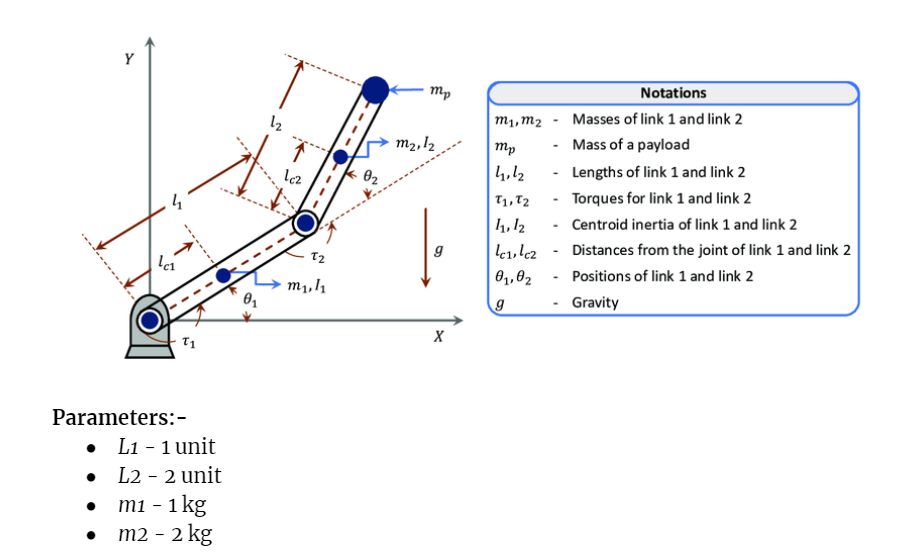

In [ ]:
L1=1
L2 =2
m1=1
m2=2

# Level 1: Navigating the Cartesian Plane [10 Points]

In [ ]:
def inverse_kinematics(x_target,y_target):
  global L1,L2
  theta2 = np.arccos((x_target**2 + y_target**2 - L1**2 - L2**2)/(2*L1*L2))
  theta1 = np.arctan2(y_target, x_target) - np.arctan2(L2 * np.sin(theta2), L1 + L2 * np.cos(theta2))
  return theta1, theta2

destination_x = -1.75
destination_y = 2.0
theta1, theta2 = inverse_kinematics(destination_x, destination_y)
print("Joint angle theta1:", np.degrees(theta1))
print("Joint angle theta2:", np.degrees(theta2))

innercoords = [L1*np.cos(theta1),L1*np.sin(theta1)]
print("Inner Coordinates:",innercoords)

Joint angle theta1: 91.03385476113975
Joint angle theta2: 58.96075998960212
Inner Coordinates: [-0.018043190412205316, 0.9998372083893202]


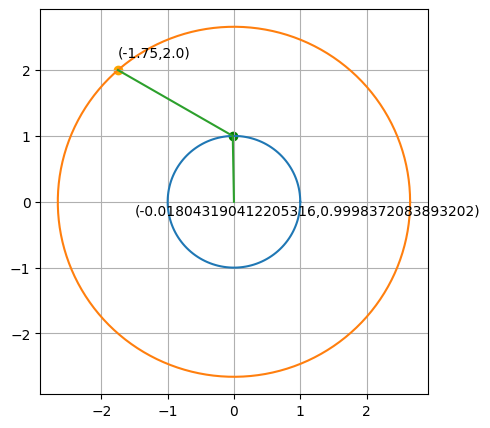

In [ ]:
theta = np.linspace( 0 , 2 * np.pi , 150 )

a = L1* np.cos( theta )
b = L1* np.sin( theta )
a1 = np.sqrt((1.75)**2 +(2)**2)* np.cos( theta )
b1 = np.sqrt((1.75)**2 +(2)**2) * np.sin( theta )
plt.figure(figsize=(5,5))

plt.plot(a,b)
plt.plot(a1,b1)


plt.plot([0,innercoords[0],destination_x],[0,innercoords[1],destination_y])

plt.scatter([innercoords[0]],[innercoords[1]],color='g')
plt.scatter([destination_x],[destination_y],color='orange')
plt.grid()

plt.text(-1.5,-0.2, f'({innercoords[0]},{innercoords[1]})', fontsize = 10)
plt.text(-1.75,2.2, f'({destination_x},{destination_y})', fontsize = 10)
plt.show()

# Level 2: Following the Smooth Trajectory [20 Points]

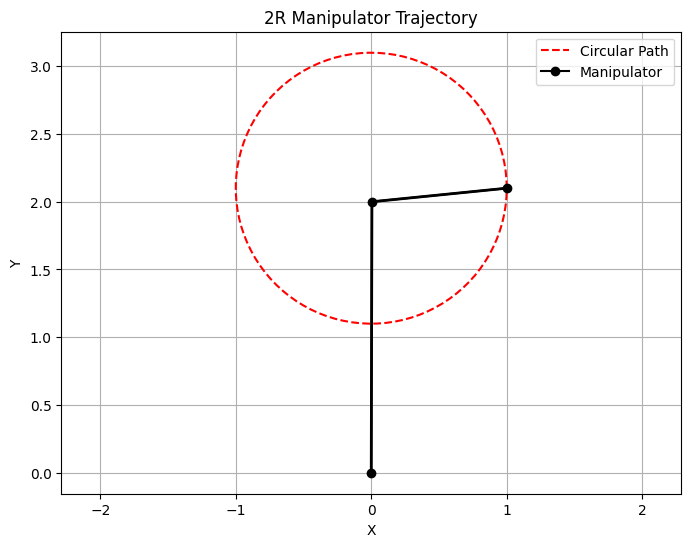

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

center = (0, 2.1)  # Center of the circular path
radius = 1  # Radius of the circular path


num_points = 100  # Number of points on the trajectory
theta = np.linspace(0, 2*np.pi, num_points)  # Angles from 0 to 2*pi
x_traj = center[0] + radius * np.cos(theta)
y_traj = center[1] + radius * np.sin(theta)
trajectory_data = np.zeros((num_points, 3))  # Each row: [x_end_effector, y_end_effector, time]


def update(frame):
    plt.cla()
    plt.plot(x_traj, y_traj, 'r--', label='Circular Path')
    x_target = x_traj[frame]
    y_target = y_traj[frame]

    #  distance from the origin to the target point
    dist_to_target = np.sqrt(x_target**2 + y_target**2)
    y_c = 0

    theta2_c =0
    D = (x_target**2 + y_target**2 - L1**2 - L2**2) / (2 * L1 * L2)

    if y_target>=2.9:
      y_target = 2.9


    # positions of the joints
    D = (x_target**2 + y_target**2 - L1**2 - L2**2) / (2 * L1 * L2)
    theta2 = np.arctan2(-np.sqrt(1 - D**2), D)
    theta1 = np.arctan2(y_target, x_target) - np.arctan2(L2 * np.sin(theta2), L1 + L2 * np.cos(theta2))

    x_end_effector = L1 * np.cos(theta1) + L2 * np.cos(theta1 + theta2)
    y_end_effector = L1 * np.sin(theta1) + L2 * np.sin(theta1 + theta2)
    x_joints = [0, L1 * np.cos(theta1), x_end_effector]
    y_joints = [0, L1 * np.sin(theta1), y_end_effector]
    y_c = y_end_effector

    theta2_c = theta2


    # Plot
    plt.plot(x_joints, y_joints, 'ko-')
    plt.plot([0, x_joints[1]], [0, y_joints[1]], 'k-', linewidth=2)  # First link
    plt.plot([x_joints[1], x_joints[2]], [y_joints[1], y_joints[2]], 'k-', linewidth=2)  # Second link
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('2R Manipulator Trajectory')
    plt.axis('equal')
    plt.legend(['Circular Path', 'Manipulator'])
    plt.grid(True)

    trajectory_data[frame, :] = [x_end_effector, y_end_effector, frame]



# animation
fig = plt.figure(figsize=(8, 6))
ani = FuncAnimation(fig, update, frames=num_points, interval=50, repeat=False)

# Save the animation as a video file
writer = FFMpegWriter(fps=15)
ani.save('2_trajectory.mp4', writer=writer)
# Save trajectory data to CSV
np.savetxt('2_trajectory_data.csv', trajectory_data, delimiter=',')

plt.show()


# Level 3:Dynamic Trajectory Manoeuvring

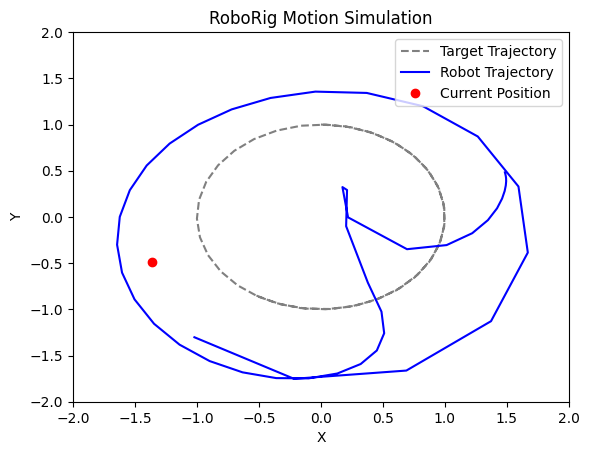

In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Function to compute the Jacobian matrix
def compute_jacobian(theta1, theta2, l1, l2):
    # Define the Jacobian matrix using the symbolic variables
    J = np.array([[-l1*np.sin(theta1)-l2*np.sin(theta1+theta2), -l2*np.sin(theta1+theta2)],
                  [l1*np.cos(theta1)+l2*np.cos(theta1+theta2), l2*np.cos(theta1+theta2)]])
    return J

# PID Controller Implementation
class PIDController:
    def __init__(self, kp, ki, kd, target_trajectory):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.target_trajectory = target_trajectory
        self.prev_error = 0
        self.integral = 0

    def update(self, current_position):
        error = self.target_trajectory - current_position
        self.integral += error
        derivative = error - self.prev_error
        output = self.kp * error + self.ki * self.integral + self.kd * derivative
        self.prev_error = error
        return output

# Define symbolic variables
theta1, theta2, theta_dot1, theta_dot2 = sp.symbols('theta1 theta2 theta_dot1 theta_dot2')
l1, l2 = sp.symbols('l1 l2')

def h(theta1, theta2, theta_dot1, theta_dot2):
    # Define symbolic functions for sin and cos
    sin1 = sp.sin(theta1)
    sin2 = sp.sin(theta2)
    cos1 = sp.cos(theta1)
    cos2 = sp.cos(theta2)

    # Express the velocity of each link
    v_x1 = -l1*sin1*theta_dot1
    v_y1 = l1*cos1*theta_dot1
    v_x2 = v_x1 - l2*(sin1*theta_dot1 + sin2*(theta_dot1 + theta_dot2))
    v_y2 = v_y1 + l2*(cos1*theta_dot1 + cos2*(theta_dot1 + theta_dot2))

    # Compute the third component of the cross product of velocity and acceleration
    h = (v_x1 * sp.diff(v_x2, theta_dot1) + v_y1 * sp.diff(v_y2, theta_dot1) +
         v_x1 * sp.diff(v_x2, theta_dot2) + v_y1 * sp.diff(v_y2, theta_dot2))

    # Simplify the expression
    h = sp.simplify(h)

    return h

# Function to compute torque
def compute_torque(theta1, theta2, theta_dot1, theta_dot2, theta_ddot1, theta_ddot2, l1, l2, m1, m2, g, h):
    # Joint space inertia matrix (assuming point masses)
    M = np.array([[m1*(l1*2) + m2(l2*2 + 2*l1*l2*np.cos(theta2)) + 2*m2*l1*l2*np.cos(theta2), m2(l2**2 + l1*l2*np.cos(theta2))],
                  [m2*(l2*2 + l1*l2*np.cos(theta2)), m2(l2**2)]])

    # # Coriolis matrix
    # C = np.array([[-h*l2*np.sin(theta2)theta_dot2, -h*l2*np.sin(theta2)(theta_dot1 + theta_dot2)],
    #               [h*l2*np.sin(theta2)*theta_dot1, 0]])
    # Coriolis matrix
    C = np.array([[-h*l2*np.sin(theta2)*theta_dot2, -h*l2*np.sin(theta2)*(theta_dot1 + theta_dot2)],
                  [h*l2*np.sin(theta2)*theta_dot1, 0]])


    # Gravity vector
    G = np.array([(m1*l1 + m2*l1)*g*np.sin(theta1) + m2*l2*g*np.sin(theta1+theta2),
                  m2*l2*g*np.sin(theta1+theta2)])

    # Joint space acceleration vector
    q_ddot = np.array([theta_ddot1, theta_ddot2])

    # Compute Jacobian matrix
    J = compute_jacobian(theta1, theta2, l1, l2)

    # Compute torque
    tau = np.dot(J.T, np.dot(M, q_ddot) + np.dot(C, np.array([theta_dot1, theta_dot2])) + G)

    return tau

# Simulation parameters
total_time = 5  # Total simulation time (seconds)
dt = 0.1  # Time step (seconds)
num_steps = int(total_time / dt)

# Target circular trajectory parameters
t = np.linspace(0, total_time, num_steps)
target_x = np.sin(2*t)
target_y = np.cos(2*t)

# Robot parameters
theta1_val = np.pi/4  # Initial joint angle 1
theta2_val = np.pi/3  # Initial joint angle 2
theta_dot1_val = 0.1  # Initial joint velocity 1
theta_dot2_val = 0.05  # Initial joint velocity 2
l1_val = 1.0  # Length of link 1
l2_val = 0.8  # Length of link 2
m1_val = 1.0  # Mass of link 1
m2_val = 0.8  # Mass of link 2
g_val = 9.81  # Acceleration due to gravity

# PID controller parameters
kp = 2.0
ki = 0.01
kd = 0.01
pid_controller = PIDController(kp, ki, kd, target_y)

# Lists to store trajectory data
trajectory_x = []
trajectory_y = []

# Simulation loop
for i in range(num_steps):
    # Compute torque using PID controller
    torque = pid_controller.update(target_y[i])

    # Compute joint accelerations
    theta_ddot1_val = torque[0] / (m1_val * (l1_val*2) + m2_val * (l2_val*2) + 2 * m2_val * l1_val * l2_val * np.cos(theta2_val))
    theta_ddot2_val = torque[1] / (m2_val * (l2_val**2) + m2_val * l1_val * l2_val * np.cos(theta2_val))

    # Update joint velocities and positions using forward Euler integration
    theta_dot1_val += theta_ddot1_val * dt
    theta_dot2_val += theta_ddot2_val * dt
    theta1_val += theta_dot1_val * dt
    theta2_val += theta_dot2_val * dt

    # Compute end effector position
    end_effector_x = l1_val * np.sin(theta1_val) + l2_val * np.sin(theta1_val + theta2_val)
    end_effector_y = l1_val * np.cos(theta1_val) + l2_val * np.cos(theta1_val + theta2_val)

    trajectory_x.append(end_effector_x)
    trajectory_y.append(end_effector_y)

# Create a function to update the plot for each frame of the animation
def update(frame):
    ax.clear()
    ax.plot(target_x, target_y, color='gray', linestyle='--', label='Target Trajectory')
    ax.plot(trajectory_x[:frame], trajectory_y[:frame], color='blue', label='Robot Trajectory')
    ax.plot(trajectory_x[frame], trajectory_y[frame], 'ro', label='Current Position')
    ax.set_title('RoboRig Motion Simulation')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.legend()

# Create a figure and axis for the animation
fig, ax = plt.subplots()
animation = FuncAnimation(fig, update, frames=num_steps, interval=50)

# Save the animation as a video file
animation.save('test.mp4', writer='ffmpeg')

plt.show()

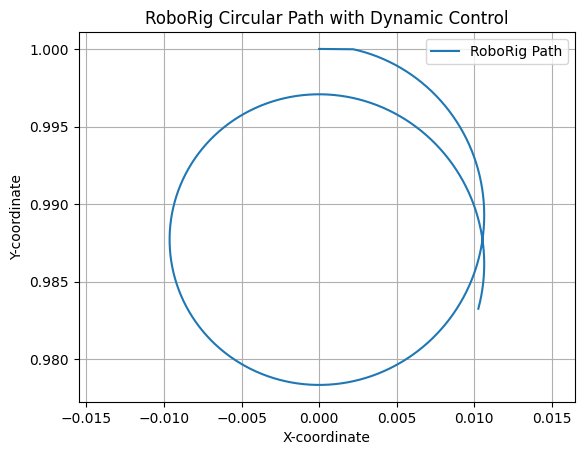

In [ ]:
plt.plot(trajectory[:, 1], trajectory[:, 2], label='RoboRig Path')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('RoboRig Circular Path with Dynamic Control')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

# Level 4

In [ ]:
# import numpy as np
# import sympy as sp

# # Function to compute the Jacobian matrix
# def compute_jacobian(theta1, theta2, l1, l2):
#     # Define the Jacobian matrix using the symbolic variables
#     J = np.array([[-l1*np.sin(theta1)-l2*np.sin(theta1+theta2), -l2*np.sin(theta1+theta2)],
#                   [l1*np.cos(theta1)+l2*np.cos(theta1+theta2), l2*np.cos(theta1+theta2)]])
#     return J


# # Define symbolic variables
# theta1, theta2, theta_dot1, theta_dot2 = sp.symbols('theta1 theta2 theta_dot1 theta_dot2')
# l1, l2 = sp.symbols('l1 l2')

# def h(theta1, theta2, theta_dot1, theta_dot2):
#     # Define symbolic functions for sin and cos
#     sin1 = sp.sin(theta1)
#     sin2 = sp.sin(theta2)
#     cos1 = sp.cos(theta1)
#     cos2 = sp.cos(theta2)

#     # Express the velocity of each link
#     v_x1 = -l1*sin1*theta_dot1
#     v_y1 = l1*cos1*theta_dot1
#     v_x2 = v_x1 - l2*(sin1*theta_dot1 + sin2*(theta_dot1 + theta_dot2))
#     v_y2 = v_y1 + l2*(cos1*theta_dot1 + cos2*(theta_dot1 + theta_dot2))

#     # Compute the third component of the cross product of velocity and acceleration
#     h = (v_x1 * sp.diff(v_x2, theta_dot1) + v_y1 * sp.diff(v_y2, theta_dot1) +
#          v_x1 * sp.diff(v_x2, theta_dot2) + v_y1 * sp.diff(v_y2, theta_dot2))

#     # Simplify the expression
#     h = sp.simplify(h)

#     return h

# # Function to compute torque
# def compute_torque(theta1, theta2, theta_dot1, theta_dot2, theta_ddot1, theta_ddot2, l1, l2, m1, m2, g, h):
#     # Joint space inertia matrix (assuming point masses)
#     M = np.array([[m1*(l1**2) + m2*(l2**2 + 2*l1*l2*np.cos(theta2)) + 2*m2*l1*l2*np.cos(theta2), m2*(l2**2 + l1*l2*np.cos(theta2))],
#                   [m2*(l2**2 + l1*l2*np.cos(theta2)), m2*(l2**2)]])

#     # Coriolis matrix
#     C = np.array([[-h*l2*np.sin(theta2)*theta_dot2, -h*l2*np.sin(theta2)*(theta_dot1 + theta_dot2)],
#                   [h*l2*np.sin(theta2)*theta_dot1, 0]])

#     # Gravity vector
#     G = np.array([(m1*l1 + m2*l1)*g*np.sin(theta1) + m2*l2*g*np.sin(theta1+theta2),
#                   m2*l2*g*np.sin(theta1+theta2)])

#     # Joint space acceleration vector
#     q_ddot = np.array([theta_ddot1, theta_ddot2])

#     # Compute Jacobian matrix
#     J = compute_jacobian(theta1, theta2, l1, l2)

#     # Compute torque
#     tau = np.dot(J.T, np.dot(M, q_ddot) + np.dot(C, np.array([theta_dot1, theta_dot2])) + G)

#     return M,C,G,q_ddot,J,tau

# # Example usage
# theta1_val = np.pi/4  # Joint angle 1
# theta2_val = np.pi/3  # Joint angle 2
# theta_dot1_val = 0.1  # Joint velocity 1
# theta_dot2_val = 0.05  # Joint velocity 2
# theta_ddot1_val = 0.01  # Joint acceleration 1
# theta_ddot2_val = 0.02  # Joint acceleration 2
# l1_val = 1.0
# l1=1
# l2=0.8  # Length of link 1
# l2_val = 0.8  # Length of link 2
# m1_val = 1.0  # Mass of link 1
# m2_val = 0.8  # Mass of link 2
# g_val = 9.81  # Acceleration due to gravity

# # Compute the value of h using the symbolic expression
# theta1, theta2, theta_dot1, theta_dot2 = sp.symbols('theta1 theta2 theta_dot1 theta_dot2')
# h_expr = h(theta1, theta2, theta_dot1, theta_dot2)
# h_value = h_expr.evalf(subs={theta1: theta1_val, theta2: theta2_val, theta_dot1: theta_dot1_val, theta_dot2: theta_dot2_val})

# # Compute torque
# M,C,G,q_dpt,J,tau = compute_torque(theta1_val, theta2_val, theta_dot1_val, theta_dot2_val, theta_ddot1_val, theta_ddot2_val, l1_val, l2_val, m1_val, m2_val, g_val, h_value)
# print("Torque:", tau)


Torque: [-24.4706666869276 -15.6269695355991]
